In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Importing all the necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Loading the dataset
data = pd.read_csv("/content/drive/MyDrive/synthetic_beverage_sales_data.csv")

In [4]:
print(data.shape)

(8999910, 11)


In [5]:
# Checking the null values
data.isnull().sum()

,0
Order_ID,0
Customer_ID,0
Customer_Type,0
Product,0
Category,0
Unit_Price,0
Quantity,0
Discount,0
Total_Price,0
Region,0


In [6]:
# Checking for any duplicate values
data.duplicated().sum()

0

In [7]:
# Checking number of unique values in column
print(data.nunique())

Order_ID         3000000
Customer_ID        10000
Customer_Type          2
Product               47
Category               4
Unit_Price         12778
Quantity             100
Discount               4
Total_Price       203842
Region                16
Order_Date          1094
dtype: int64


In [8]:
# Checking columns and its datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Order_ID       object 
 1   Customer_ID    object 
 2   Customer_Type  object 
 3   Product        object 
 4   Category       object 
 5   Unit_Price     float64
 6   Quantity       int64  
 7   Discount       float64
 8   Total_Price    float64
 9   Region         object 
 10  Order_Date     object 
dtypes: float64(3), int64(1), object(7)
memory usage: 755.3+ MB


In [9]:
# Printing initial 5 rows
print(data.head())

  Order_ID Customer_ID Customer_Type             Product     Category  \
0     ORD1     CUS1496           B2B          Vio Wasser        Water   
1     ORD1     CUS1496           B2B               Evian        Water   
2     ORD1     CUS1496           B2B              Sprite  Soft Drinks   
3     ORD1     CUS1496           B2B  Rauch Multivitamin       Juices   
4     ORD1     CUS1496           B2B        Gerolsteiner        Water   

   Unit_Price  Quantity  Discount  Total_Price             Region  Order_Date  
0        1.66        53      0.10        79.18  Baden-Württemberg  2023-08-23  
1        1.56        90      0.10       126.36  Baden-Württemberg  2023-08-23  
2        1.17        73      0.05        81.14  Baden-Württemberg  2023-08-23  
3        3.22        59      0.10       170.98  Baden-Württemberg  2023-08-23  
4        0.87        35      0.10        27.40  Baden-Württemberg  2023-08-23  


In [10]:
# Drop the ID columns as they are not relevant for model
df = data.drop(columns=['Order_ID', 'Customer_ID'])

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Customer_Type  object 
 1   Product        object 
 2   Category       object 
 3   Unit_Price     float64
 4   Quantity       int64  
 5   Discount       float64
 6   Total_Price    float64
 7   Region         object 
 8   Order_Date     object 
dtypes: float64(3), int64(1), object(5)
memory usage: 618.0+ MB


## Feature Engineering


In [12]:
# Customer_Type has only two unique values. So we can apply Label Encoding Here.
le = LabelEncoder()
df['Customer_Type'] = le.fit_transform(df['Customer_Type'])

In [13]:
# As Category column has few unique values we can one-hot encode
df_encoded = pd.get_dummies(df, columns=['Category'], drop_first=True)

In [14]:
# Product and Region columns have many unique values so we use Target Encoding
df_encoded['Product'] = df_encoded.groupby('Product')['Total_Price'].transform('mean')
df_encoded['Region'] = df_encoded.groupby('Region')['Total_Price'].transform('mean')

In [15]:
# Convert 'Order_Date' to datetime format
df_encoded['Order_Date'] = pd.to_datetime(df_encoded['Order_Date'])

# Extract components from the 'Order_Date'
df_encoded['Year'] = df_encoded['Order_Date'].dt.year
df_encoded['Month'] = df_encoded['Order_Date'].dt.month
df_encoded['Day'] = df_encoded['Order_Date'].dt.day
df_encoded['Day_of_Week'] = df_encoded['Order_Date'].dt.dayofweek # 0: Monday, 6: Sunday
df_encoded['Quarter'] = df_encoded['Order_Date'].dt.quarter

In [16]:
# Drop the original 'Order_Date' column after extracting relevant components
data_cleaned = df_encoded.drop(columns=['Order_Date'])

In [17]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Customer_Type         int64  
 1   Product               float64
 2   Unit_Price            float64
 3   Quantity              int64  
 4   Discount              float64
 5   Total_Price           float64
 6   Region                float64
 7   Category_Juices       bool   
 8   Category_Soft Drinks  bool   
 9   Category_Water        bool   
 10  Year                  int32  
 11  Month                 int32  
 12  Day                   int32  
 13  Day_of_Week           int32  
 14  Quarter               int32  
dtypes: bool(3), float64(5), int32(5), int64(2)
memory usage: 678.1 MB


In [18]:
# Total_Price has outliers which can affect model
data_cleaned = data_cleaned[data_cleaned['Total_Price'] < data_cleaned['Total_Price'].quantile(0.99)]  # Remove top 1% extreme values


In [19]:
# Let's split the data into train and test
X = data_cleaned.drop(columns=['Total_Price']) # Features
y = data_cleaned['Total_Price'] # Target variable
# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42
)
# Check the shape of the resulting datasets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (6236937, 14)
Testing data shape: (2672973, 14)


In [20]:
# Convert to XGBoost DMatrix format (for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on test data
y_pred = model.predict(dtest)


In [21]:
# Evaluating the model performance using three common metrics: MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error: Measures the average magnitude of errors in predictions
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error: Measures the average of the squares of errors
rmse = np.sqrt(mse)  # Root Mean Squared Error: Square root of MSE, gives error in the original unit of measurement

# Printing out the evaluation metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 2.219344816756548
MSE: 102.04795040135743
RMSE: 10.101878558038472


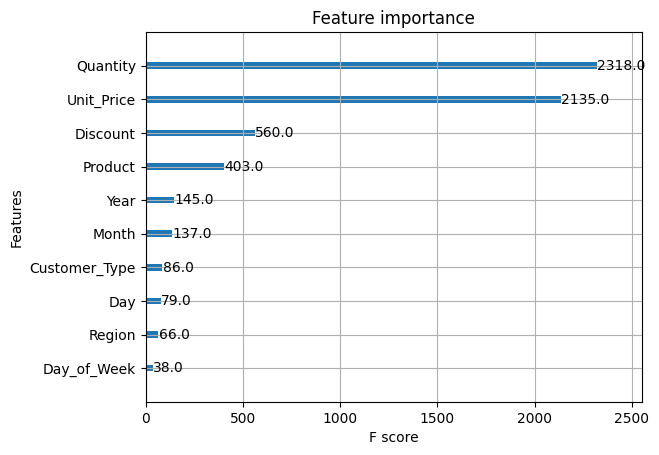

In [22]:
# Plotting the feature importance of the XGBoost model to visualize which features contribute most to the predictions
xgb.plot_importance(model)
plt.show()

After experimenting with several machine learning models, including Linear Regression, Gradient Boosting, and XGBoost, we found that XGBoost provided the most accurate predictions for Total_Price. The training time for other models was significantly higher, and XGBoost produced consistent results with lower MAE and RMSE. Therefore, XGBoost was selected as the final model for predicting the total price in this project.

In [23]:
# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
